# Intro

Our simulations use a Soft-Particle (SP) interaction potential (one that penalizes geometric overlaps).  The ratio of the temperature to the SP interaction strength is what determines how much the soft particles can geometrically overlap.  The SP model enables smoothly interpolating between SP and Hard-Particle (HP) (0-overlap) behavior through tuning this ratio, with lower temperatures giving more HP behavior.  For densities below jamming, there is a critical temperature where the HP limit is reached.  Any time-dependent quantities measured below this point will approximately match, regardless of their temperatures, provided the time-axis is scaled by the thermal time i.e. $t \sqrt{T}$.

As we are generally interested in studying the effects related to the particle geometry, we want to be in the HP regime.  From preliminary tests, done in the $\texttt{09/run-compression}$ directory, we know that this is roughly obtained for $T~10^{-5}$ or lower.  Here, we will show this in a slightly more rigorous way.  Explicitly, we will measure time averaged quantities such as pressure, average overlaps, and the radial distribution function, as well as time dependent quantities such as the diffusion coefficient, for a range of temperatures and densities.  Here, the full length of dimensionless time $t \sqrt{T}$ is nearly constant for each $T$ investigated.  We want to see the value of $T$, below which, all measured quantities are approximately unchanged.

For each $T$, we will start at $\phi~0.7$ and incrementally compress by $\Delta \phi = 0.02$, setting the temperature with a simple rescaling thermostat.  Following each incremental compression, we allow the system to relax in NVE for upwards of $10M$ steps (depending on the temperature).  We then take our measurements using the trajectories during this time.  We repeat until we roughly approach $\phi_J$.

Caveats:

A fully rigorous approach would quantify what it means to be approximately unchanged by comparing to the run-to-run variance; however, it takes about 2 days to get all the data for just one run so this is not entirely feasible.

Our initial density is close to $\phi_G$ so we only have a few reliable translational diffusion measurements.  It would be nice to have more; however, we wanted to also measure structural quantities like $g(r)$ and explicit overlaps in high density regions.  Back to the previous point, this would just take more time so we leave it as an obvious limitation of the current work.


# To run:

Run the script $\texttt{run\_compression\_disk.py}$ to collect the disk data as a baseline.  This is significantly faster than the bumpy particle case.  To run that, run $\texttt{run\_compression\_rigid\_bumpy.py}$.  This runs 25 systems simultaneously, each of a different $N_v$ and $\mu_{eff}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pydpmd as dp
from scipy.optimize import minimize
from matplotlib.colors import LogNorm

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.min())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])

In [2]:
def get_values_from_data(root, temp, dt, sid, show_plots=False, has_angular=False):
    phi_values = []
    D_values = []
    n_values = []
    r2_values = []
    r0_values = []
    overlap_values = []
    dimless_overlap_values = []
    pressure_values = []
    
    if has_angular:
        aD_values = []
        an_values = []
        ar2_values = []
        nv_values = []
        mu_eff_values = []

    if show_plots:
        fig, ax = plt.subplots(1, 2 + has_angular, figsize=(10, 5), constrained_layout=True)

    i = 0
    phi_norm = plt.Normalize(vmin=0.7, vmax=0.85)
    temp_norm = LogNorm(vmin=1e-6, vmax=1e-4)
    cmap = plt.cm.viridis
    while os.path.exists(fname := os.path.join(root, f'dynamics_{i}_results.npz')):
        i += 1
        data = np.load(fname)
        
        # plot the MSD
        t = data['t'] * np.sqrt(temp) * dt
        m = data['msd'][:, sid]
        if has_angular:
            am = m[:, 1]
            m = m[:, 0]
        n_expected = 1
        D, n, r2 = fit_log(t, m, n=n_expected, min_cut_pct=10, max_cut_pct=0.9)
        if has_angular:
            D_a, n_a, r2_a = fit_log(t, am, n=n_expected, min_cut_pct=10, max_cut_pct=0.9)
        if show_plots:
            ax[0].plot(t, m, c=cmap(phi_norm(data['packing_fraction'])))
            ax[0].plot(t, D * t ** n_expected, c=cmap(phi_norm(data['packing_fraction'])), linestyle='--')
            if has_angular:
                ax[1].plot(t, am, c=cmap(phi_norm(data['packing_fraction'])))
                ax[1].plot(t, D_a * t ** n_expected, c=cmap(phi_norm(data['packing_fraction'])), linestyle='--')
        # plot the g(r)
        r = data['r']
        g = data['g'][sid, 0, :]
        r0 = get_peak_location(r, g, window_pct=0.95)
        if show_plots:
            ax[1 + has_angular].plot(r, g, c=cmap(phi_norm(data['packing_fraction'])))
            ax[1 + has_angular].scatter(r0, np.max(g), c=cmap(phi_norm(data['packing_fraction'])), marker='x')

        # append the values to the lists
        phi_values.append(data['packing_fraction'][sid])
        D_values.append(D)
        n_values.append(n)
        r2_values.append(r2)
        r0_values.append(r0)
        overlap_values.append(data['overlap'][sid])
        dimless_overlap_values.append(data['dimless_overlap'][sid])
        pressure_values.append(data['pressure'][sid])
        if has_angular:
            aD_values.append(D_a)
            an_values.append(n_a)
            ar2_values.append(r2_a)
            nv_values.append(data['nv'][sid])
            mu_eff_values.append(data['mu_eff'][sid])

    if show_plots:
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(r'$t \sqrt{T}$', fontsize=16)
        ax[0].set_ylabel(r'$MSD$', fontsize=16)
        if has_angular:
            ax[1].set_xlabel(r'$t \sqrt{T}$', fontsize=16)
            ax[1].set_ylabel(r'$MSAD$', fontsize=16)
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
        ax[1 + has_angular].set_xlabel(r'$r$', fontsize=16)
        ax[1 + has_angular].set_ylabel(r'$g(r)$', fontsize=16)
        sm = plt.cm.ScalarMappable(norm=phi_norm, cmap=cmap)
        sm.set_array(phi_values)
        cbar = plt.colorbar(sm, ax=ax[1 + has_angular], label=r'$\phi$')
        plt.suptitle(f'Temp: {temp:.1e}')
        plt.show()
    
    vals = {
        'phi': phi_values,
        'D': D_values,
        'n': n_values,
        'r2': r2_values,
        'r0': r0_values,
        'overlap': overlap_values,
        'dimless_overlap': dimless_overlap_values,
        'pressure': pressure_values
    }
    if has_angular:
        vals['aD'] = aD_values
        vals['an'] = an_values
        vals['ar2'] = ar2_values
        vals['nv'] = nv_values
        vals['mu_eff'] = mu_eff_values
    return {k: np.array(v) for k, v in vals.items()}

/tmp/ipykernel_967580/3935211163.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(values['phi'], values['D'], c=cmap(temp_norm(temp)))
/tmp/ipykernel_967580/3935211163.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax0_2.scatter(values['phi'], values['r2'], c=cmap(temp_norm(temp)), alpha=0.5, marker='x')
/tmp/ipykernel_967580/3935211163.py:21: UserWarning: *c* argument looks like a single numeric RGB 

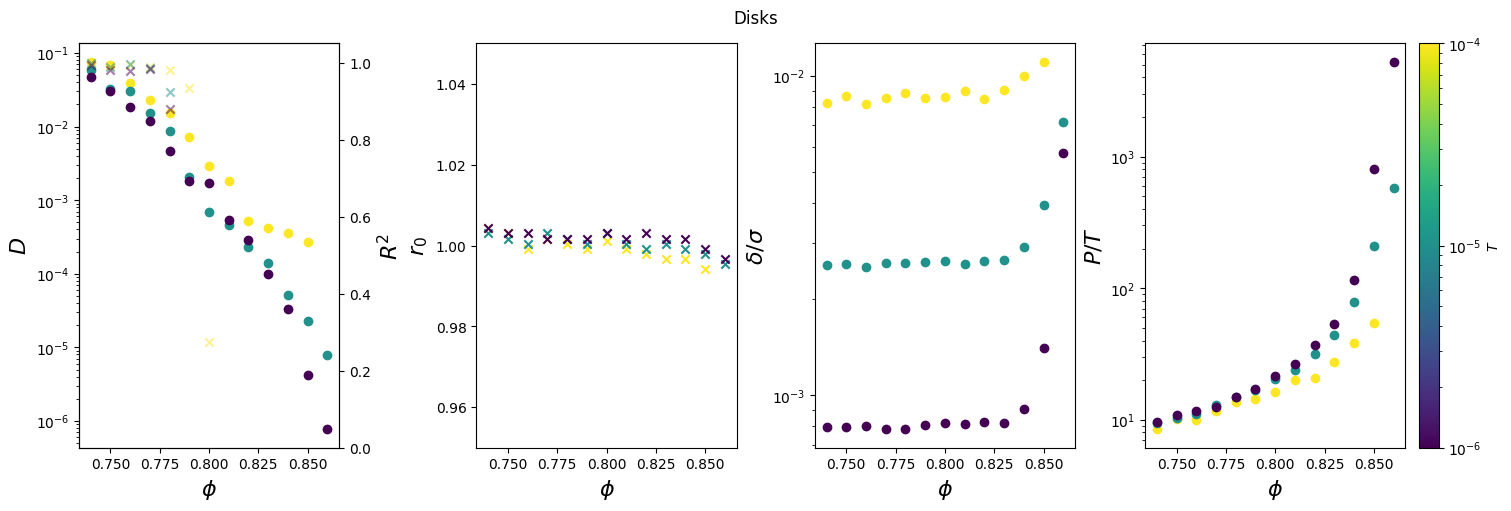

In [3]:
dt = 5e-2
sid = 0
show_plots = False
temps = [1e-4, 1e-5, 1e-6]

temp_norm = LogNorm(vmin=min(temps), vmax=max(temps))
cmap = plt.cm.viridis
base = '/home/mmccraw/dev/data/10-03-25/disk_compression_T_'

fig, ax = plt.subplots(1, 4, figsize=(15, 5), constrained_layout=True)
ax0_2 = ax[0].twinx()
for temp in temps:
    root = base + f'{temp:.3e}/'
    values = get_values_from_data(root, temp, dt, sid, show_plots)
    
    # plot the diffusion coefficient and its R^2 value
    ax[0].scatter(values['phi'], values['D'], c=cmap(temp_norm(temp)))
    ax0_2.scatter(values['phi'], values['r2'], c=cmap(temp_norm(temp)), alpha=0.5, marker='x')
    
    # plot the location of the first peak in g(r)
    ax[1].scatter(values['phi'], values['r0'], c=cmap(temp_norm(temp)), marker='x')

    # plot the average particle overlap normalized by the small particle diameter
    ax[2].scatter(values['phi'], values['dimless_overlap'], c=cmap(temp_norm(temp)))

    # plot the pressure
    ax[3].scatter(values['phi'], values['pressure'] / temp, c=cmap(temp_norm(temp)))

ax[0].set_yscale('log')
ax0_2.set_ylim(0, 1.05)
ax[1].set_ylim(0.95, 1.05)
ax[2].set_yscale('log')
ax[3].set_yscale('log')
for a in ax:
    a.set_xlabel(r'$\phi$', fontsize=16)
ax[0].set_ylabel(r'$D$', fontsize=16)
ax0_2.set_ylabel(r'$R^2$', fontsize=16)
ax[1].set_ylabel(r'$r_0$', fontsize=16)
ax[2].set_ylabel(r'$\delta/\sigma$', fontsize=16)
ax[3].set_ylabel(r'$P/T$', fontsize=16)
sm = plt.cm.ScalarMappable(norm=temp_norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax[-1], label=r'$T$')
plt.suptitle('Disks')
plt.show()

/tmp/ipykernel_967580/4117078341.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(values['phi'], values['D'], c=cmap(temp_norm(temp)))
/tmp/ipykernel_967580/4117078341.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax0_2.scatter(values['phi'], values['r2'], c=cmap(temp_norm(temp)), alpha=0.5, marker='x')
/tmp/ipykernel_967580/4117078341.py:25: UserWarning: *c* argument looks like a single numeric RGB 

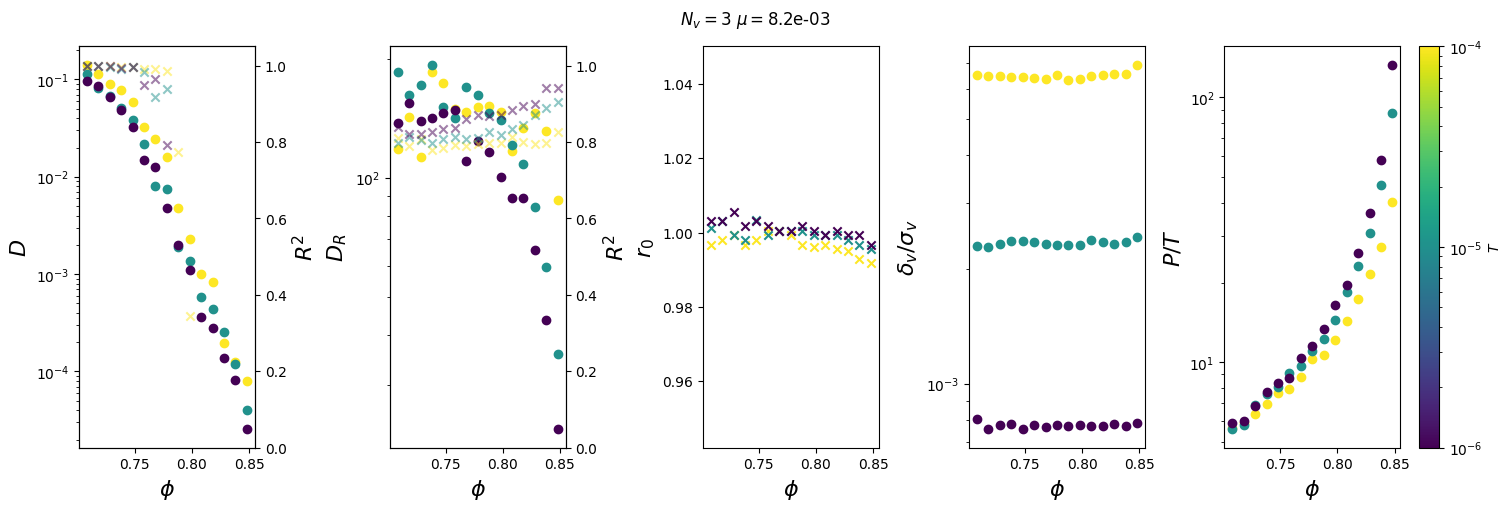

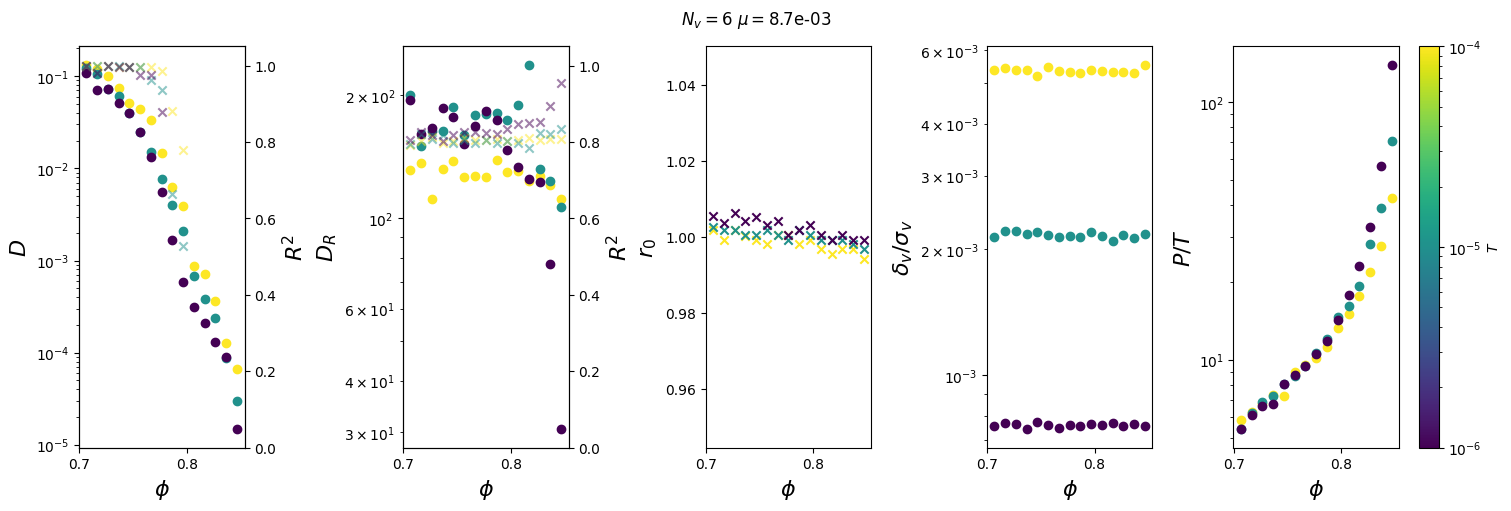

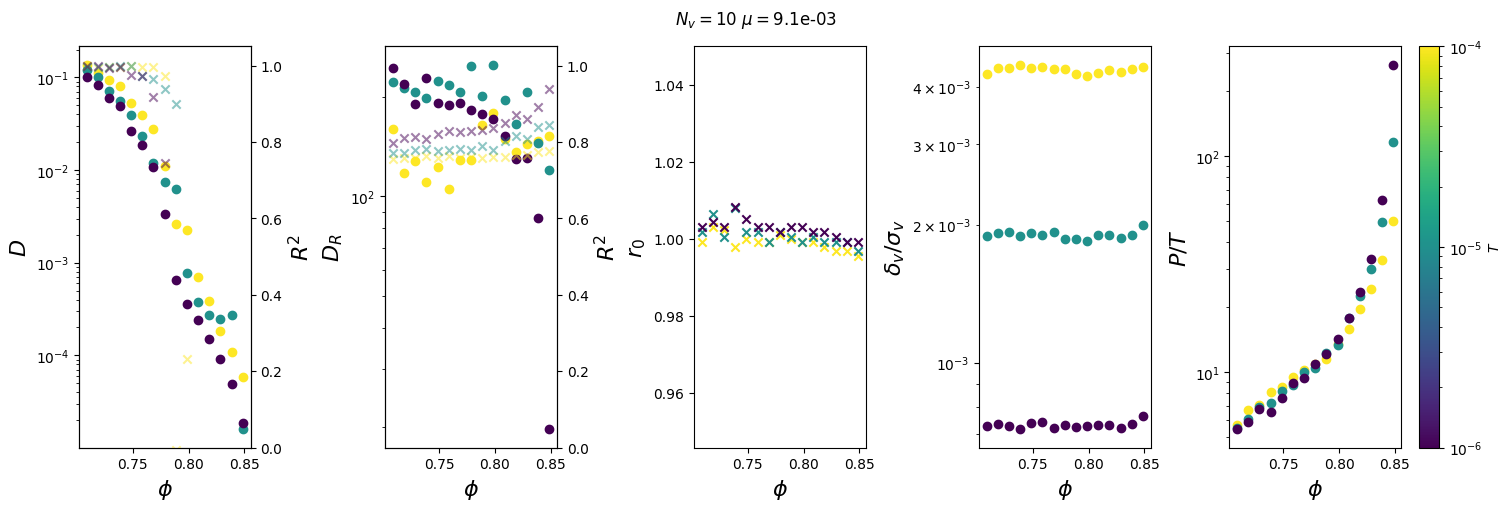

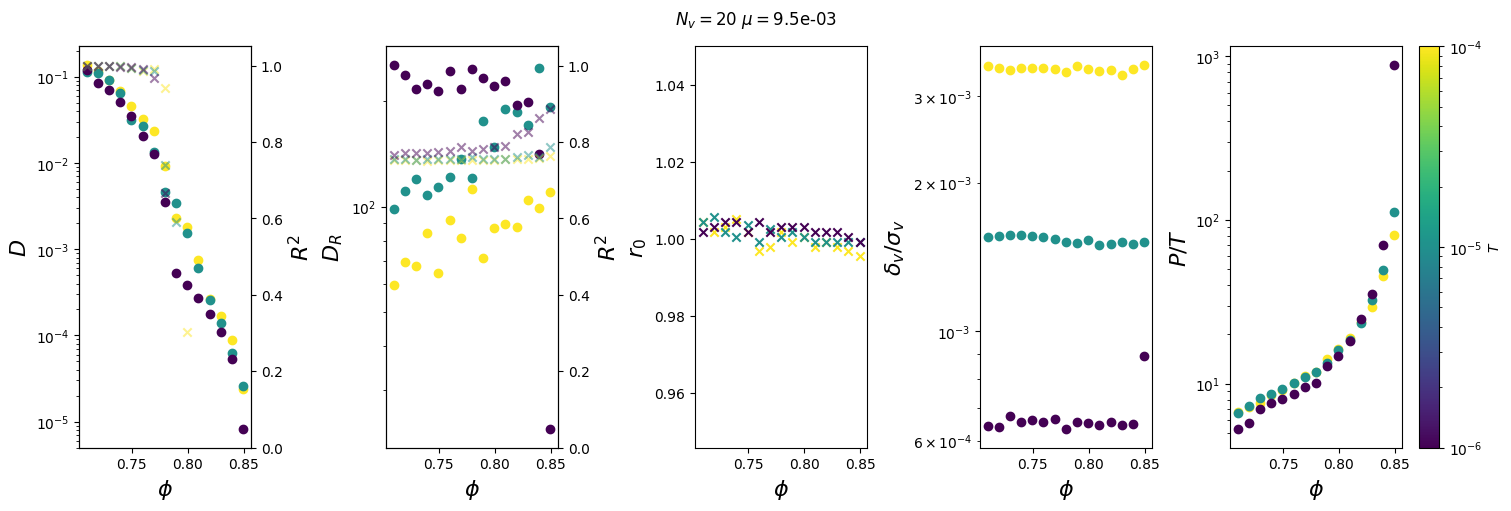

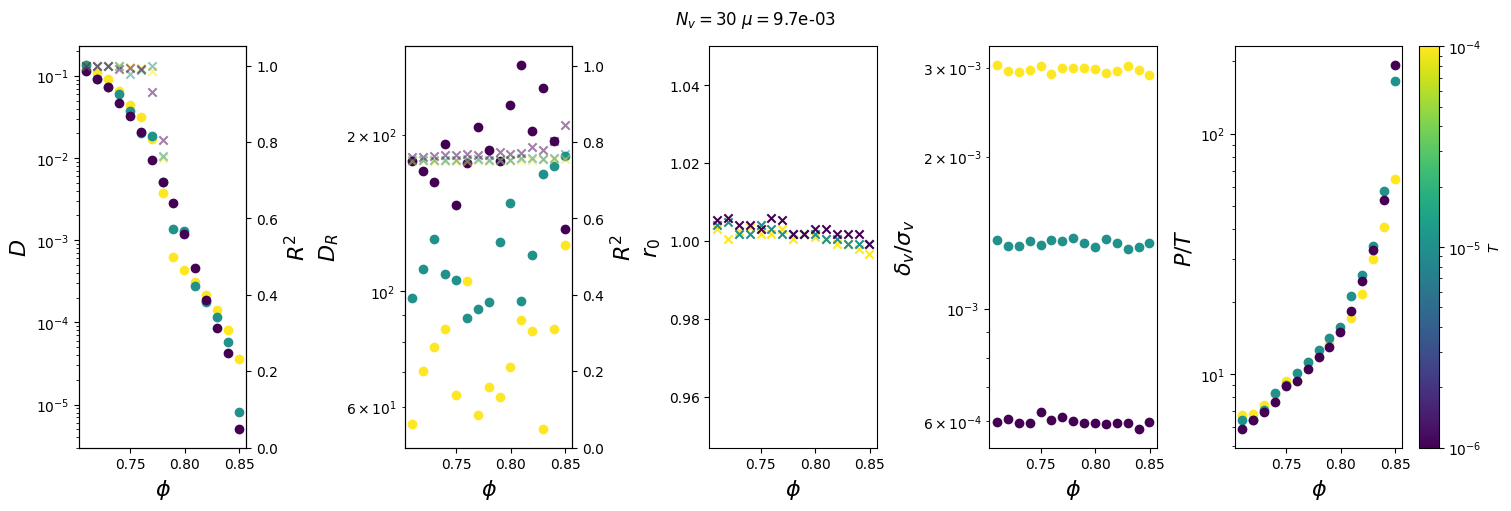

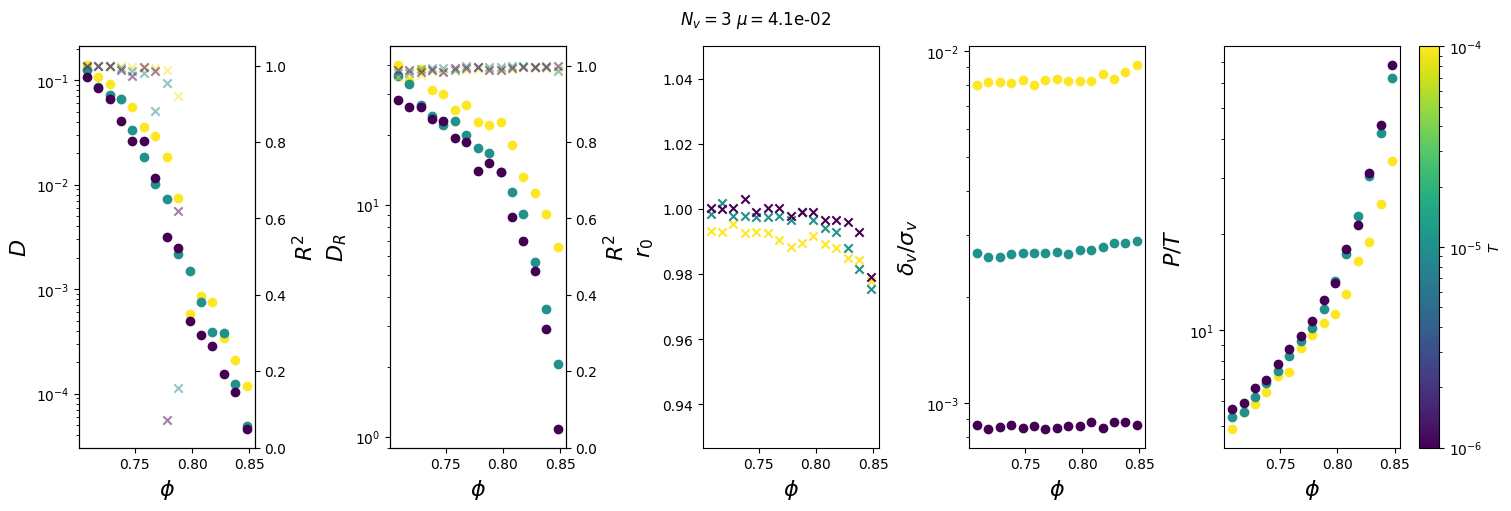

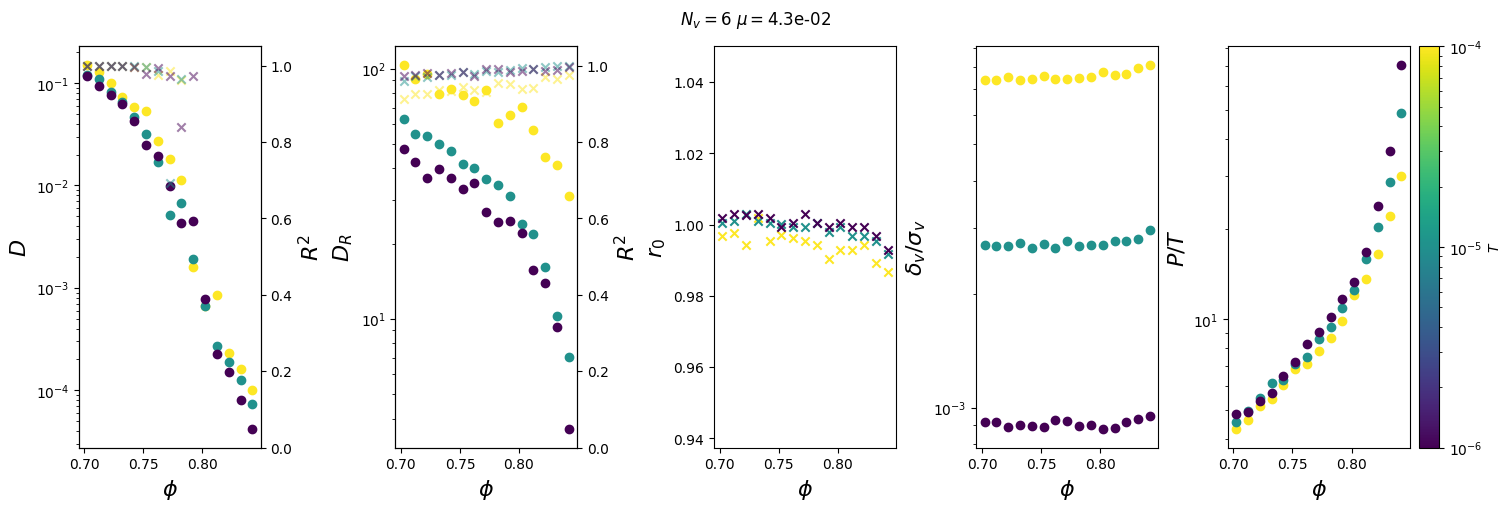

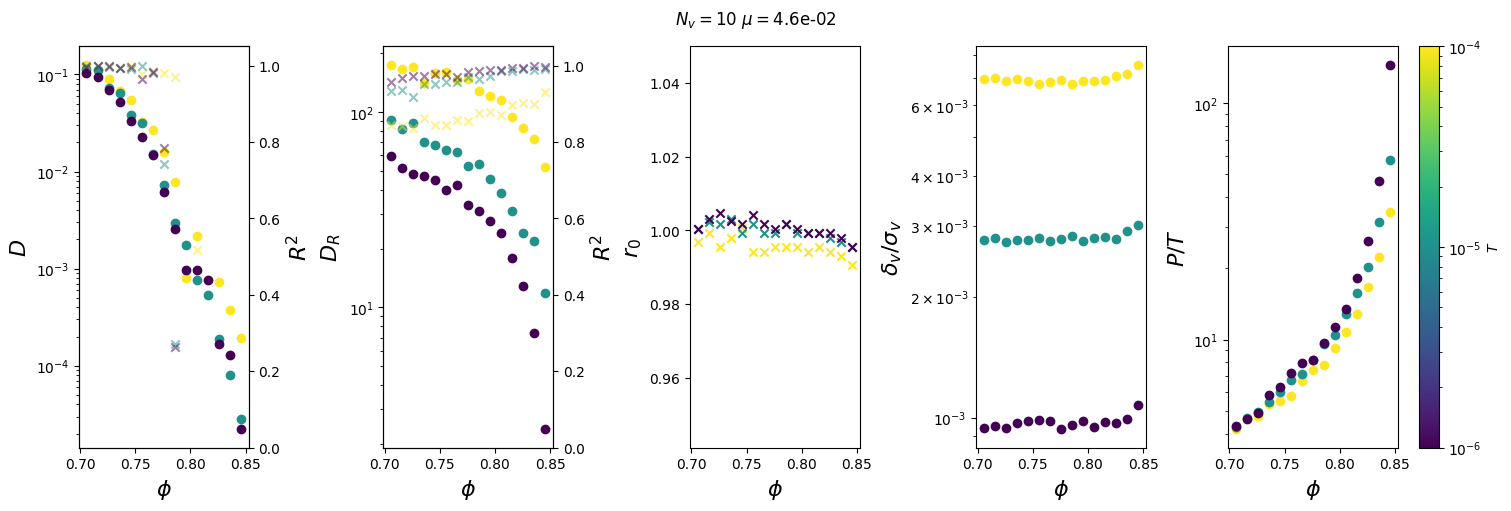

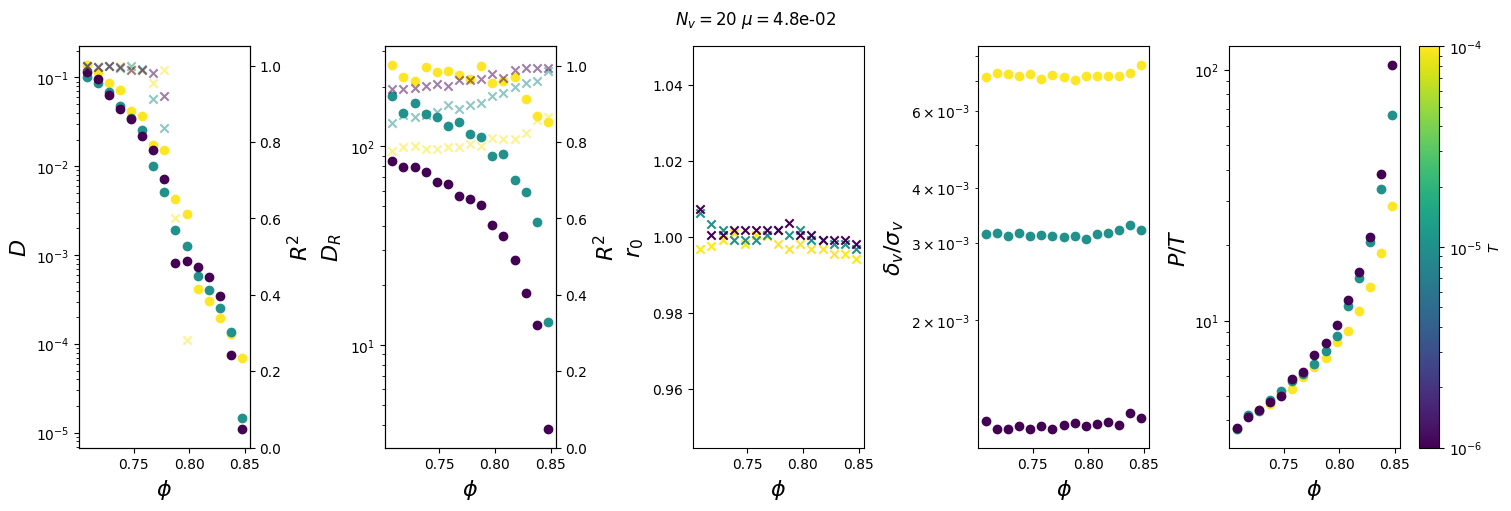

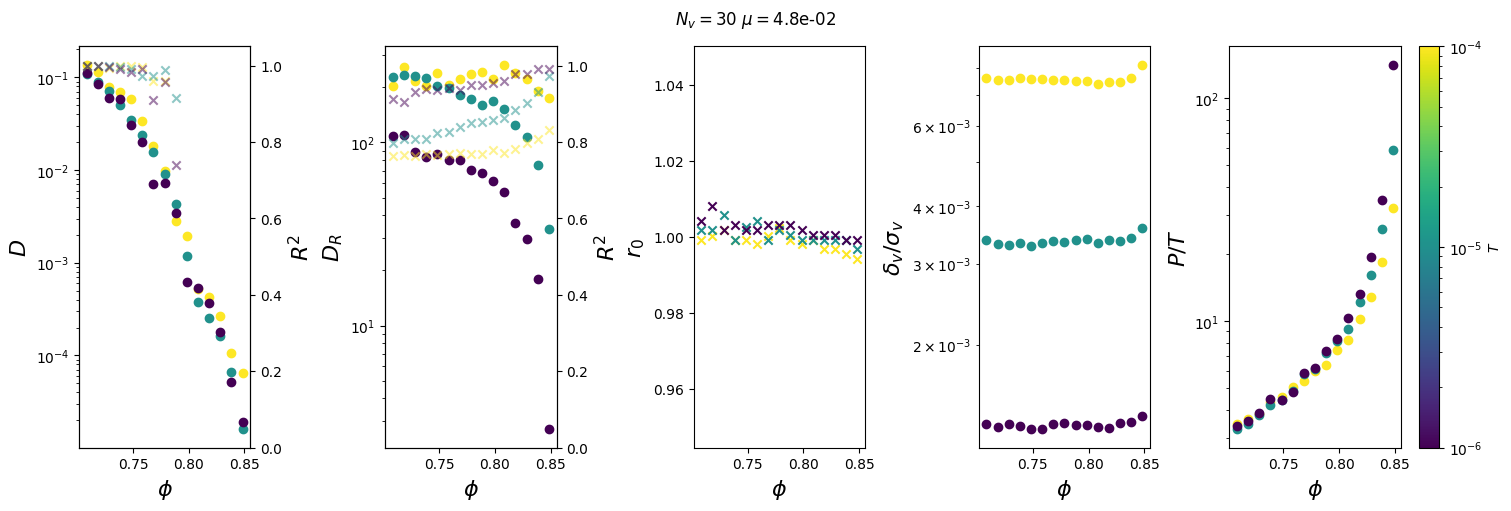

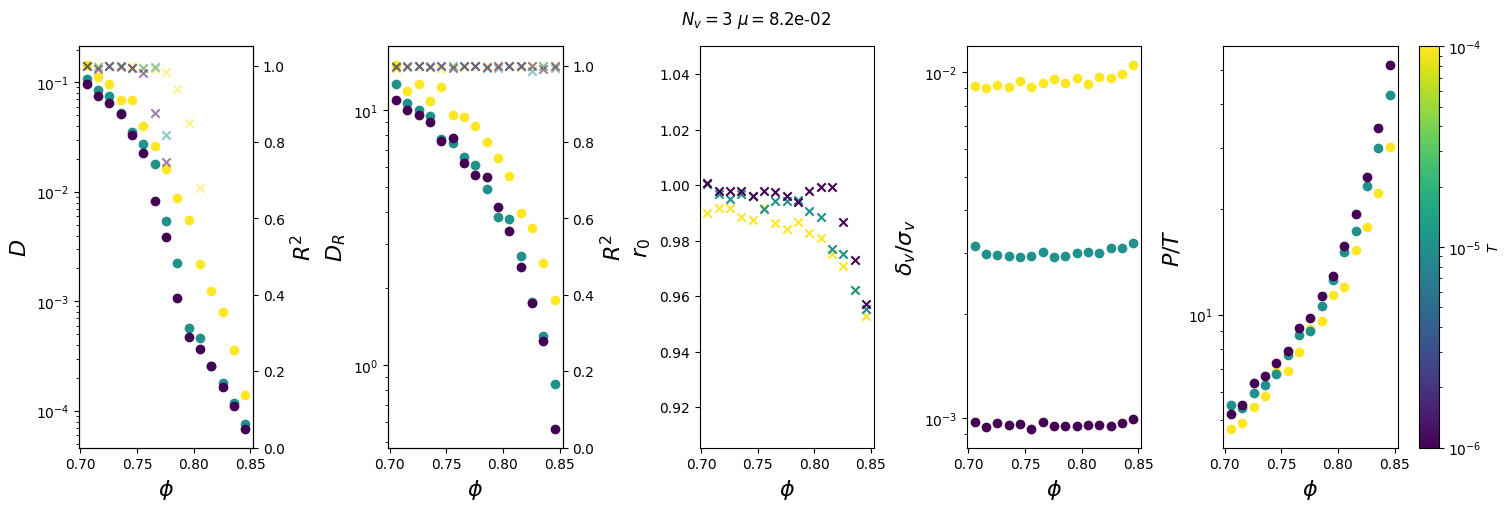

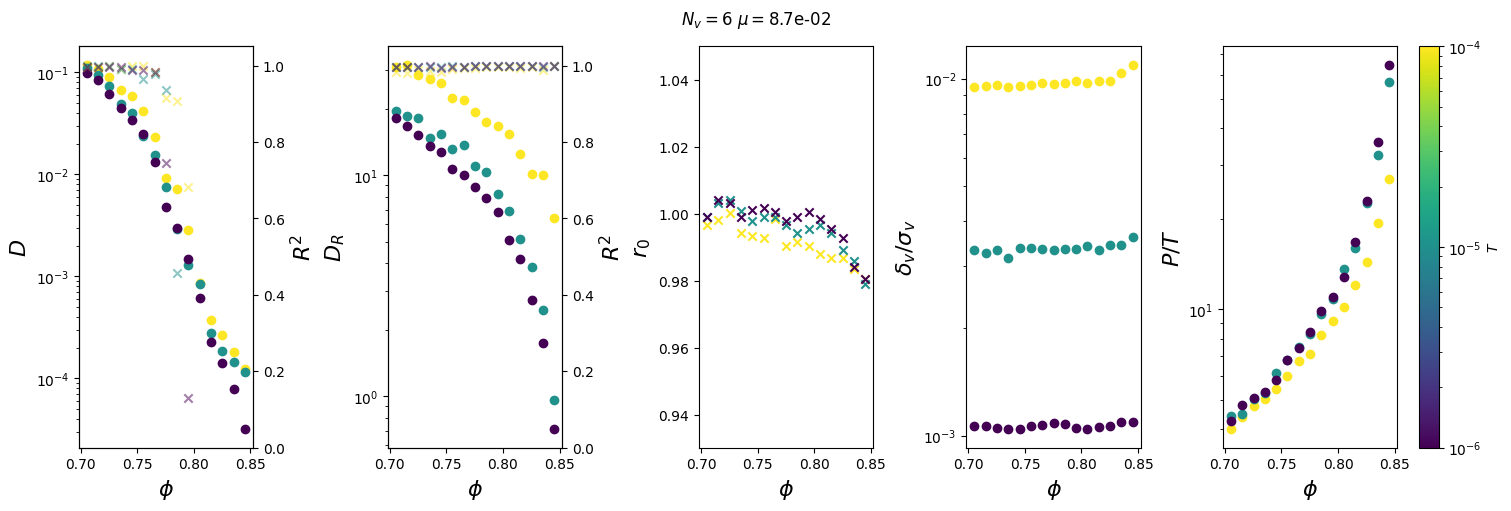

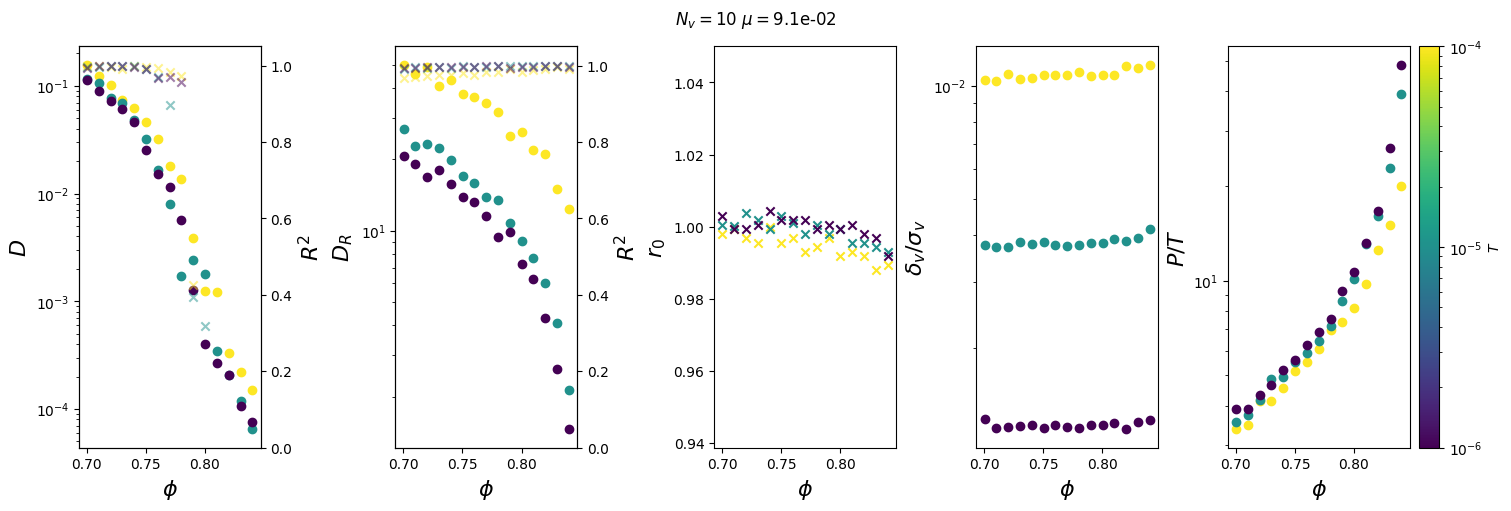

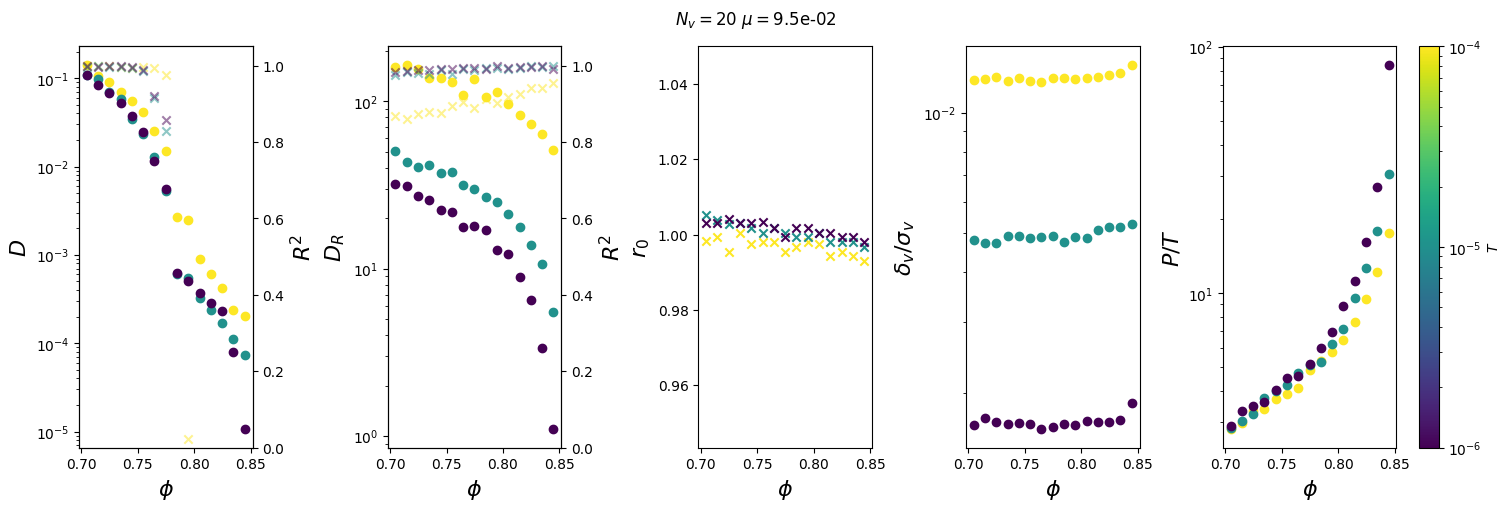

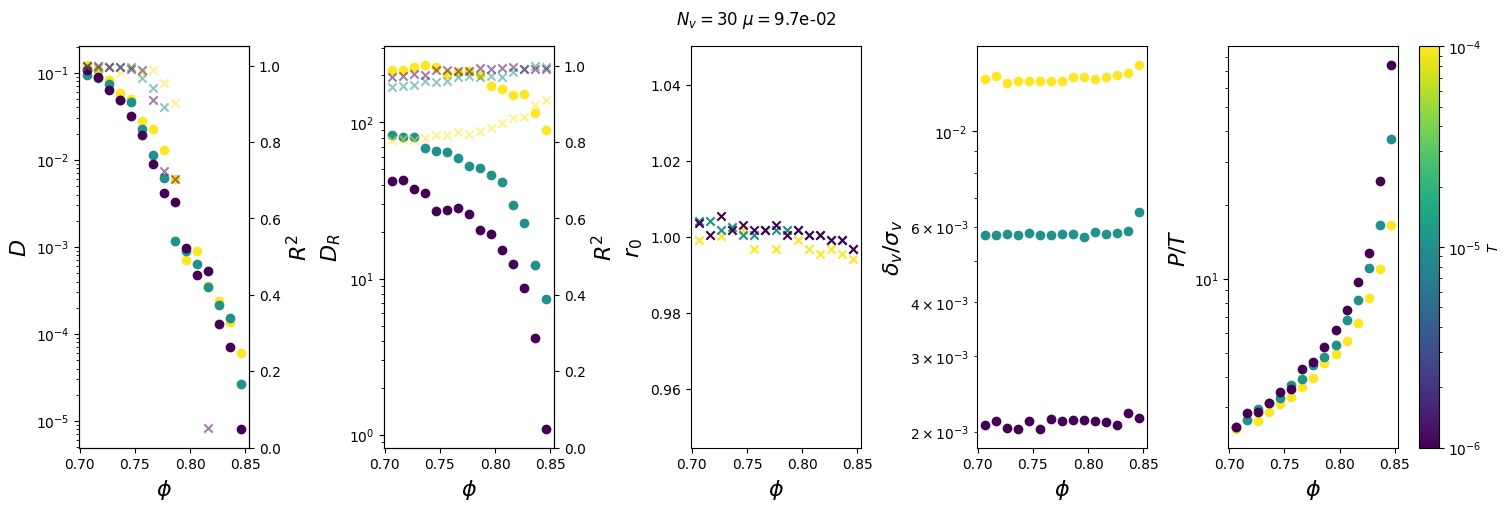

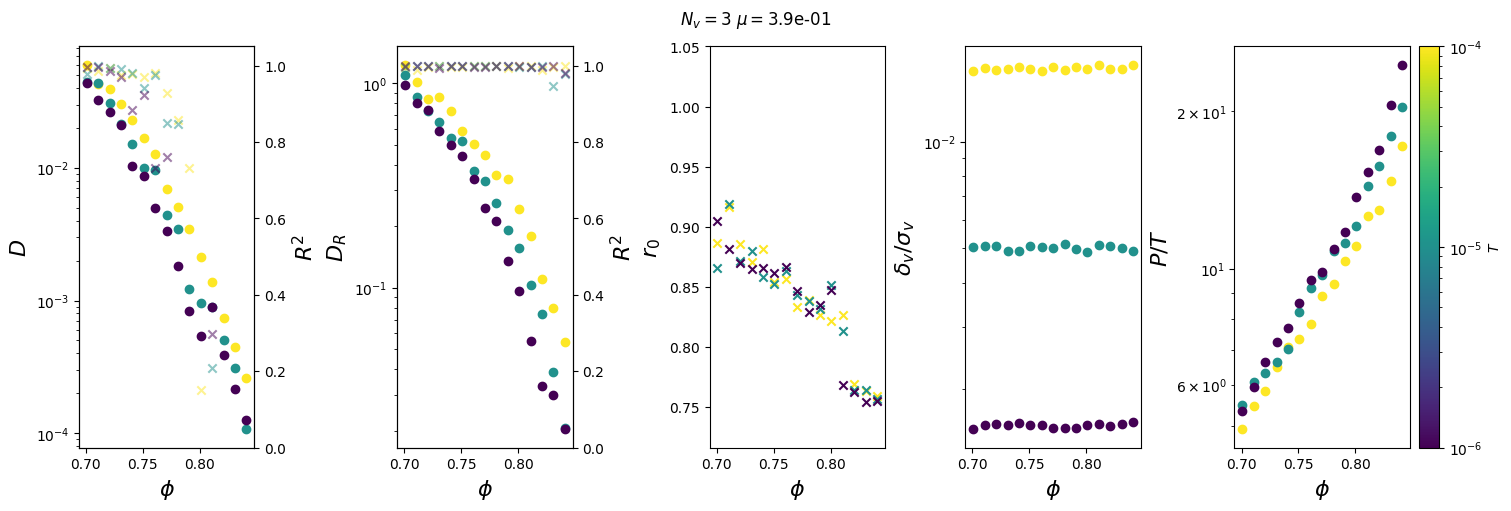

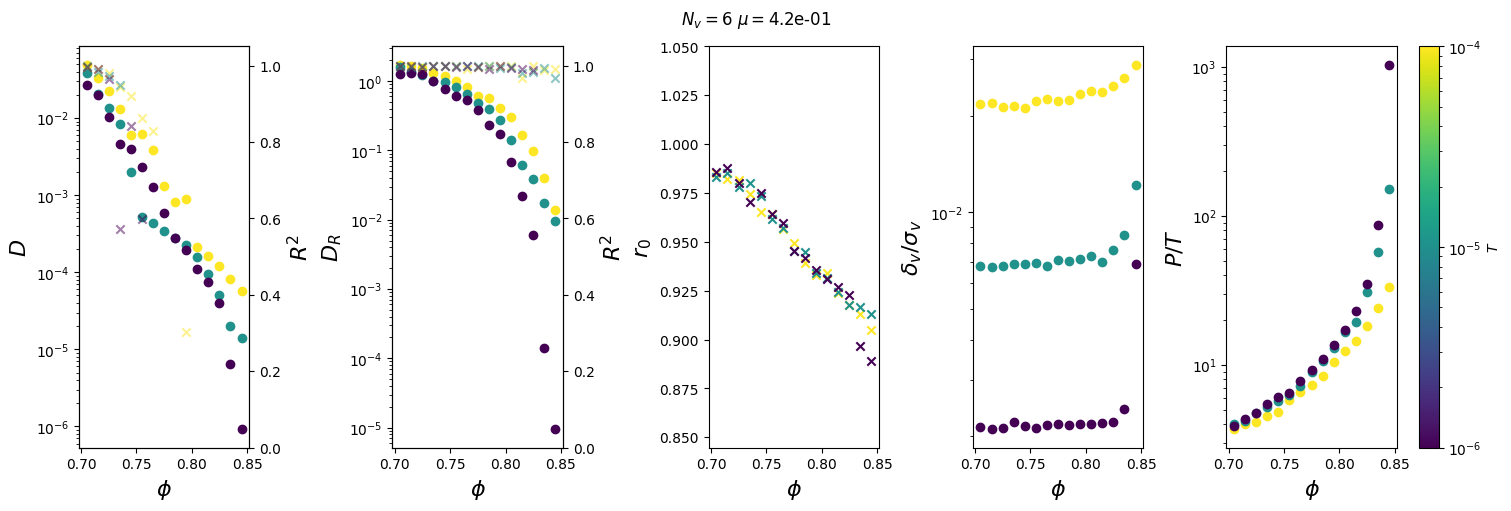

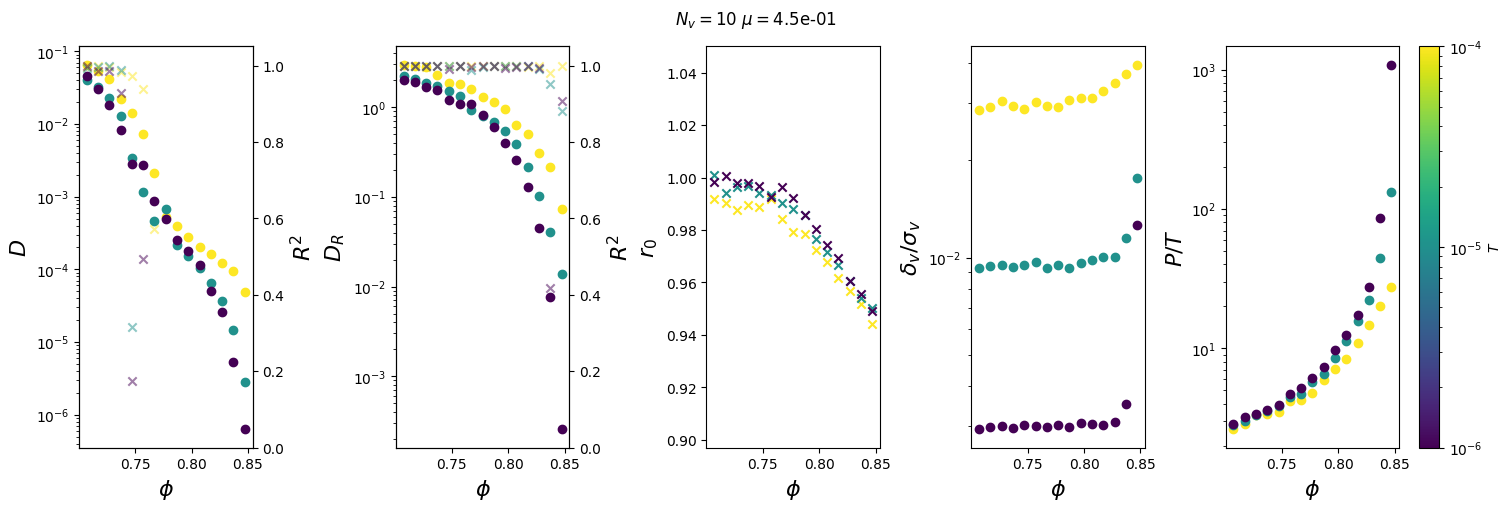

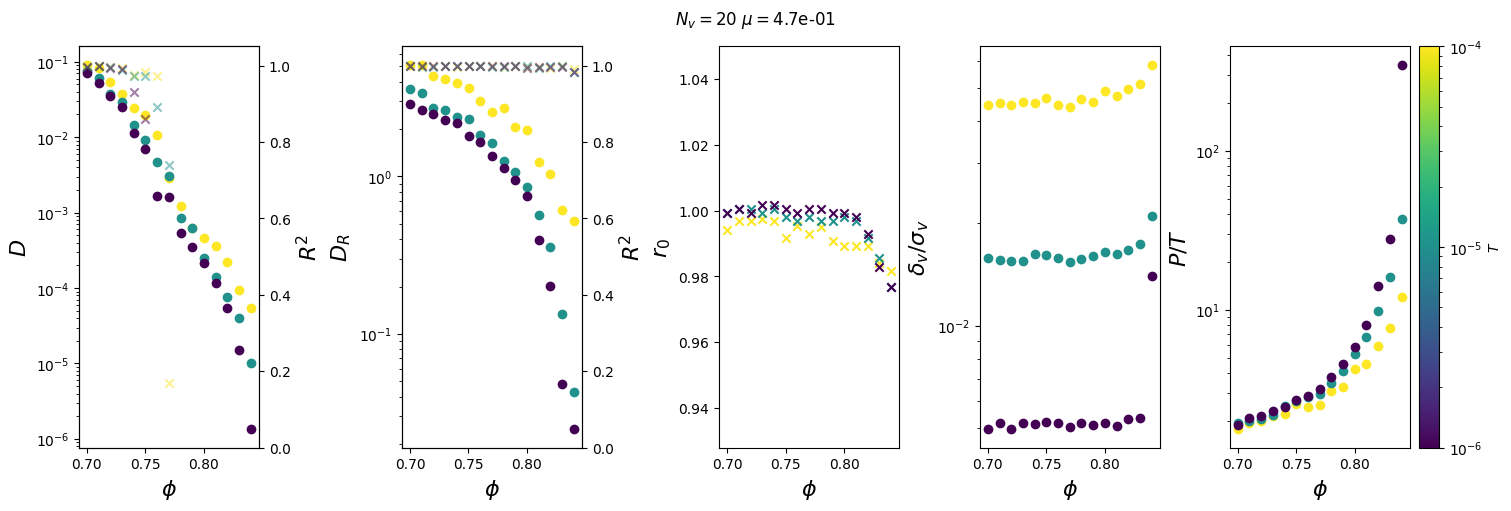

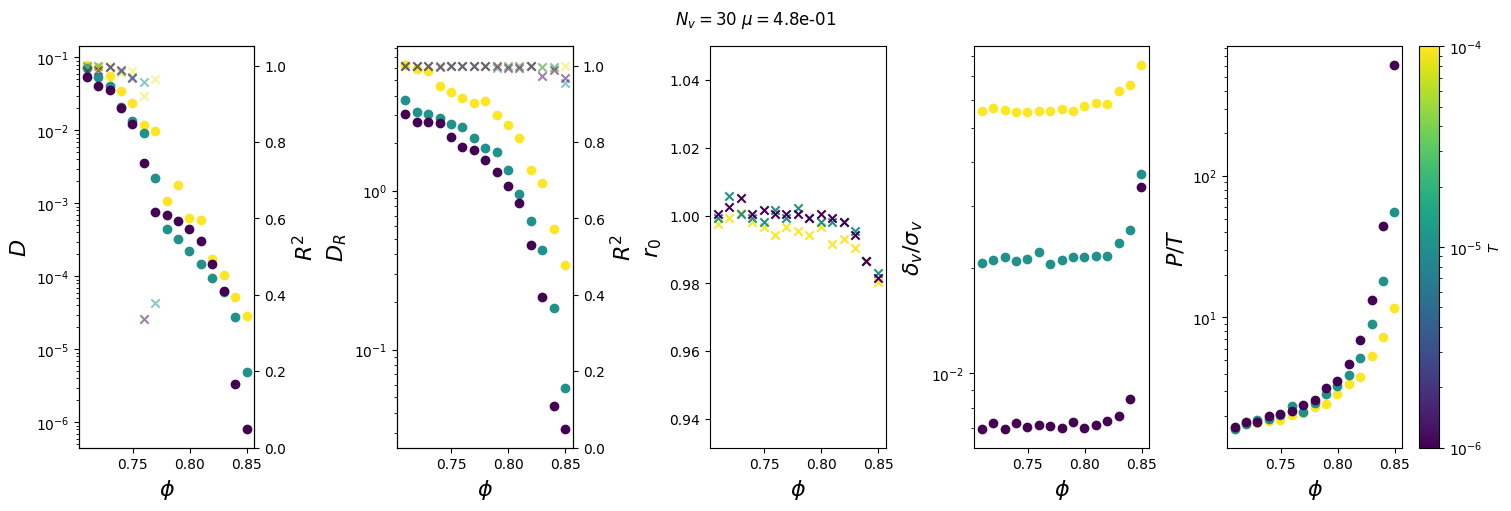

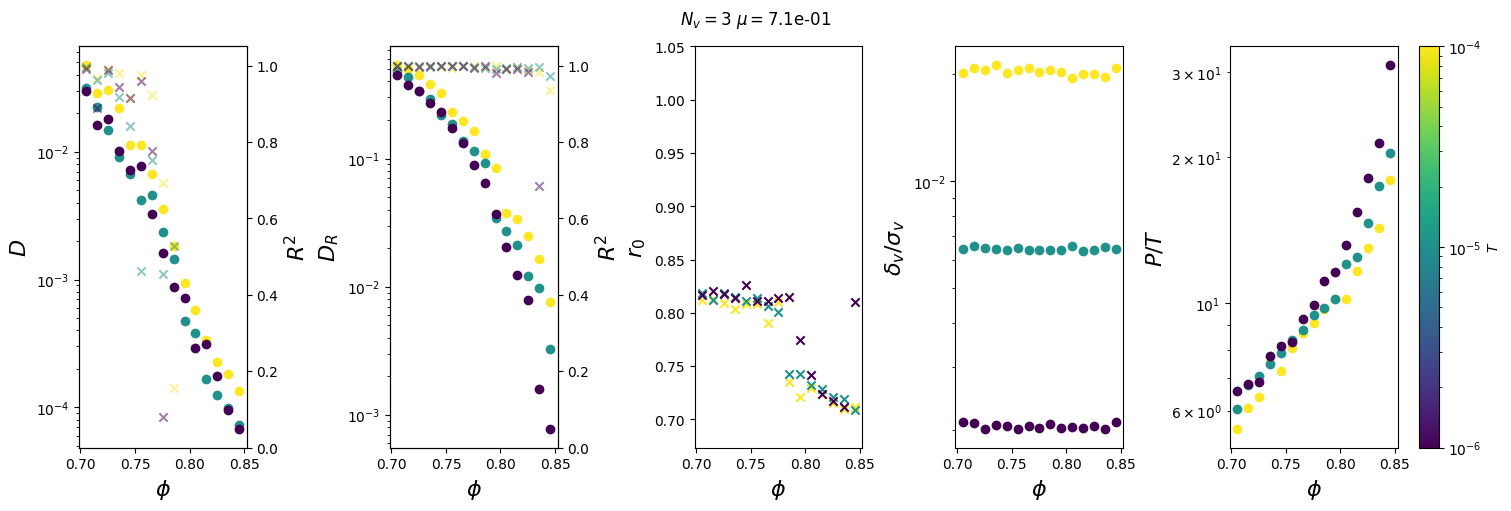

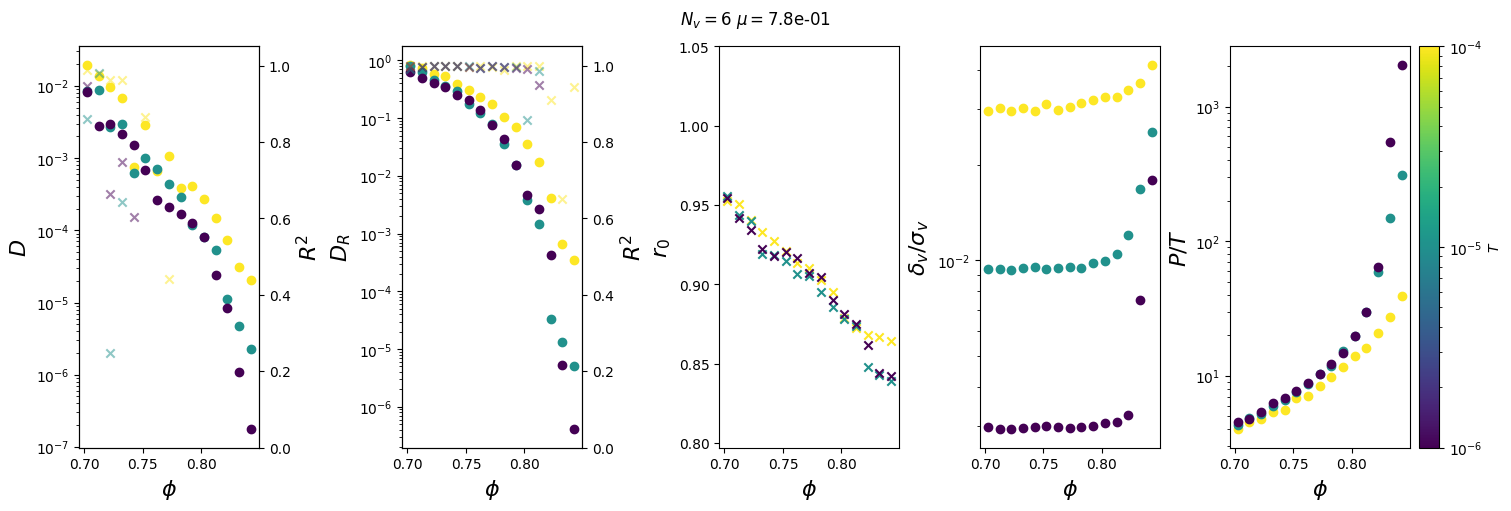

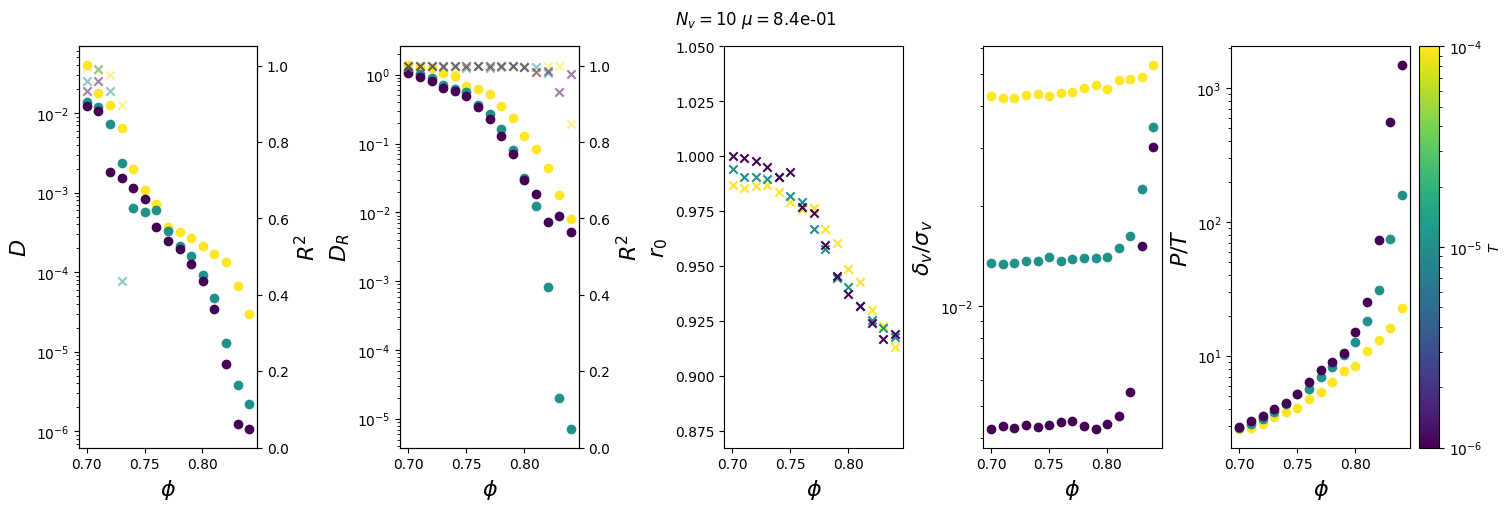

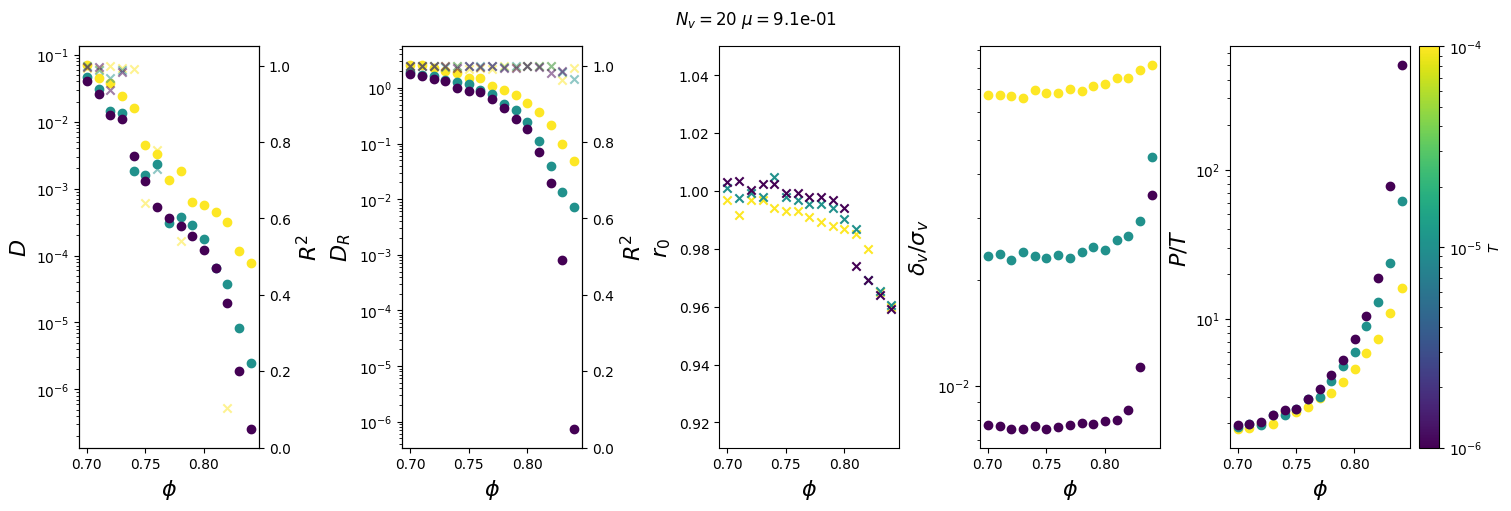

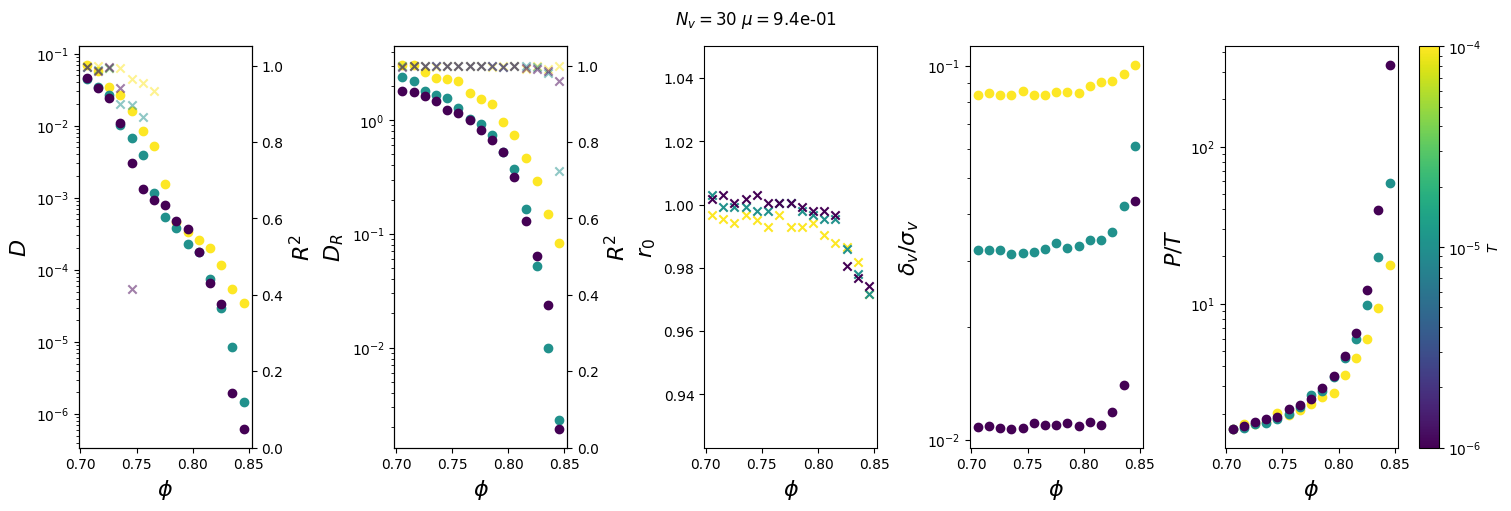

In [4]:
dt = 5e-2
show_plots = False
temps = [1e-4, 1e-5, 1e-6]

temp_norm = LogNorm(vmin=min(temps), vmax=max(temps))
cmap = plt.cm.viridis
base = '/home/mmccraw/dev/data/10-03-25/rb_compression_T_'

for sid in range(25):
    fig, ax = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
    ax0_2 = ax[0].twinx()
    ax1_2 = ax[1].twinx()

    min_r0 = np.inf

    for temp in temps:
        root = base + f'{temp:.3e}/'
        values = get_values_from_data(root, temp, dt, sid, show_plots, has_angular=True)
        
        # plot the diffusion coefficient and its R^2 value
        ax[0].scatter(values['phi'], values['D'], c=cmap(temp_norm(temp)))
        ax0_2.scatter(values['phi'], values['r2'], c=cmap(temp_norm(temp)), alpha=0.5, marker='x')

        # plot the rotational diffusion coefficient and its R^2 value
        ax[1].scatter(values['phi'], values['aD'], c=cmap(temp_norm(temp)))
        ax1_2.scatter(values['phi'], values['ar2'], c=cmap(temp_norm(temp)), alpha=0.5, marker='x')
        
        # plot the location of the first peak in g(r)
        ax[2].scatter(values['phi'], values['r0'], c=cmap(temp_norm(temp)), marker='x')
        min_r0 = min(min_r0, min(values['r0']))

        # plot the average vertex overlap normalized by the vertex diameter
        ax[3].scatter(values['phi'], values['dimless_overlap'], c=cmap(temp_norm(temp)))

        # plot the pressure
        ax[4].scatter(values['phi'], values['pressure'] / temp, c=cmap(temp_norm(temp)))

    ax[0].set_yscale('log')
    ax0_2.set_ylim(0, 1.05)
    ax[1].set_yscale('log')
    ax1_2.set_ylim(0, 1.05)
    ax[2].set_ylim(min_r0 * 0.95, 1.05)
    ax[3].set_yscale('log')
    ax[4].set_yscale('log')
    for a in ax:
        a.set_xlabel(r'$\phi$', fontsize=16)
    ax[0].set_ylabel(r'$D$', fontsize=16)
    ax0_2.set_ylabel(r'$R^2$', fontsize=16)
    ax[1].set_ylabel(r'$D_R$', fontsize=16)
    ax1_2.set_ylabel(r'$R^2$', fontsize=16)
    ax[2].set_ylabel(r'$r_0$', fontsize=16)
    ax[3].set_ylabel(r'$\delta_v/\sigma_v$', fontsize=16)
    ax[4].set_ylabel(r'$P/T$', fontsize=16)
    sm = plt.cm.ScalarMappable(norm=temp_norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=ax[-1], label=r'$T$')
    plt.suptitle(fr'$N_v=${(values["nv"][0]-1):.0f} $\mu=${values["mu_eff"][0]:.1e}')
    plt.show()

Looking at static, dynamic, and structural quantities, it seems that the hard particle limit is obtained between $T=10^{-5}$ and $T=10^{-6}$.

Good.

Seemingly the rotational diffusion coefficient (when rotational diffusion is actually observed - pay careful attention to the $R^2$!) is the most telling sign.